# Distributed Hybrid Plant - Residential Example

In this example we will ...



### Import required modules

Start by importing the necessary modules and packaged and setting up our working environment.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from floris import TimeSeries
from floris.layout_visualization import plot_turbine_points
from hopp import ROOT_DIR
from hopp.utilities.keys import set_nrel_key_dot_env
from hopp.simulation import HoppInterface
from hopp.tools.design.wind.turbine_library_tools import load_distributed_turbine_options
from hopp.utilities.utilities import load_yaml
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

set_nrel_key_dot_env()


/Users/egrant/Documents/projects/HOPP/examples/log/hybrid_systems_2025-02-21T11.34.02.083348.log


### Load inputs and create simulation model

Create an instance of the `HoppInterface` class by providing it a dictionary of inputs.

We can choose a wind turbine from the

    num_turbines: 56
    turbine_name: "BergeyExcel15_15.6kW_9.6"
    model_name: 'floris'
    floris_config: !include floris_v4_template.yaml
    resource_parse_method: "weighted_average"
    adjust_air_density_for_elevation: True
    store_turbine_performance_results: False

In [2]:
example_dir = ROOT_DIR.parent / "examples"
input_filepath = os.path.join(str(example_dir),"inputs","08-distributed-wind-solar-residential.yaml")
hopp_config = load_yaml(input_filepath)

### Simulate

In [3]:
hi = HoppInterface(hopp_config)
hi.simulate(project_life = 1)
hybrid_plant = hi.system

FLORIS is the system model...
Simulating wind farm output in FLORIS...


<PolarAxes: >

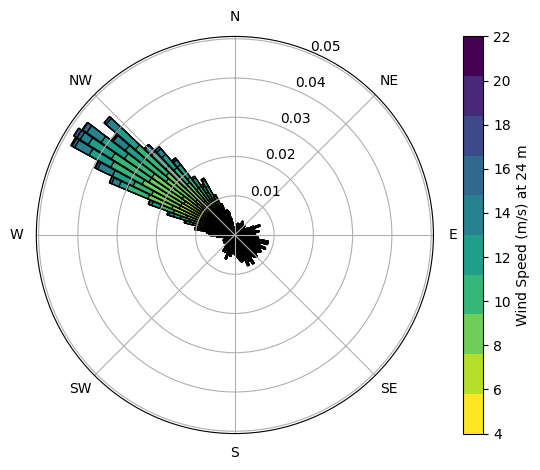

In [4]:
time_series = TimeSeries(
    wind_directions=hybrid_plant.wind._system_model.wind_dirs[0:8760],
    wind_speeds=hybrid_plant.wind._system_model.speeds[0:8760],
    turbulence_intensities=hybrid_plant.wind._system_model.fi.core.flow_field.turbulence_intensities[0]
)

wind_rose = time_series.to_WindRose(wd_edges=np.arange(0, 360, 3.0), ws_edges=np.arange(2.0, 24.0, 2.0))
fig, ax = plt.subplots(subplot_kw={"polar": True})

hub_ht = int(hybrid_plant.site.wind_resource.hub_height_meters)
wind_rose.plot(ax=ax,legend_kwargs={"label": f"Wind Speed (m/s) at {hub_ht} m"})

<Axes: >

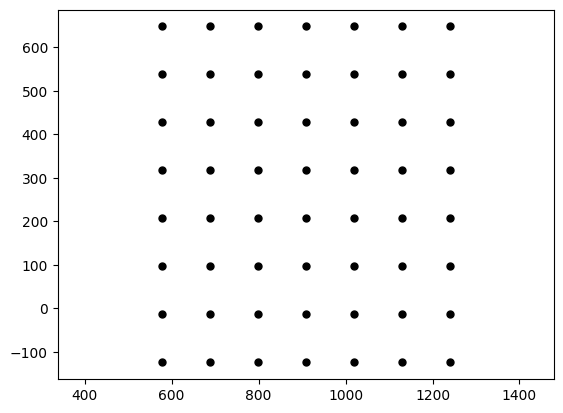

In [5]:
fig, ax = plt.subplots(1,1)
plot_turbine_points(hybrid_plant.wind._system_model.fi,ax=ax)

The list of available turbines from the turbine-models library that are categorized as distributed are:

In [6]:
load_distributed_turbine_options()

['CF11_11kW_9.36',
 'EntegrityEW50_50kW_15',
 'EWT_DW61-1000',
 'NPS100B-24C_95kW_24.4',
 'NPS100C-21_100kW_20.7',
 'Bestwind30_27.2kW_13.1',
 'FortisMontana_3.31kW_5.04',
 'CF15_15kW_11.15',
 'XzeresSkystream3.7_2.1kW_3.7',
 'CF10(PhaseA)_10kW_11.15',
 'Jacobs31-20_12kW_9.45',
 'NPS100C-28_90kW_28',
 'BergeyExcel10_8.9kW_7',
 'PikaT701_1.5kW_3',
 'EWT_DW52-900',
 'SWIFT_1kW_2.1',
 'NPS100B-21_100kW_20.7',
 'VestasV29_225kW_29',
 'GhrepowerFD21-50_61.2kW_21.5',
 'NPS100C-28_90kW_27.6',
 'EWT_DW54-X-1000',
 '2019COE_DW20_20kW_12.4',
 'VestasV27_225kW_27',
 'EWT_DW58-1000',
 'NPS100C-24_95kW_24.4',
 'EWT_DW54-900',
 'CF20_20kW_13.1',
 'NPS100B-24_95kW_23.6',
 'BergeyExcel15_15.6kW_9.6',
 'SD6_5.2kW_5.5',
 'NPS100C-27_90kW_27.4',
 'Kestrele400nb_2.5kW_4',
 '2019COE_DW100_100kW_27.6',
 'CF11(PhaseA)_11kW_11.15',
 'NPS60C-24_60kW_24.4']